# Introduction

## Prêt à mener la mission ?

Vous êtes consultant pour <a href="https://olist.com/">Olist</a>, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.


Votre rôle est d’accompagner Olist dans leur projet de monter une équipe Data et leur premier cas d’usage Data Science autour de la segmentation client.


Vous venez de rejoindre Olist dans un contexte de recrutement intensif afin de monter leur équipe Data. En effet, ils font d’abord appel à des consultants comme vous en renfort sur les sujets les plus critiques en attendant d'internaliser les compétences. Avant de réaliser la segmentation client, on vous attribue une première mission pour aider Fernanda, Lead Data Analyst chez Olist. 


Après avoir étudié les éléments partagés par Fernanda vous vous mettez au travail.


------------------------

## Quelques jours plus tard
 

Cette urgence résolue, vous pouvez enfin passer à votre mission principale : Olist souhaite que vous fournissiez à ses équipes d'e-commerce une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.


Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.
 

Vous devrez fournir à l’équipe Marketing **une description actionable** de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.


**<u>Les données</u>**

Pour cette mission, Olist vous fournit une <a href="https://course.oc-static.com/projects/olist.db">base de données</a> anonymisée comportant des informations sur l’historique des commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.
 

Vous devez aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.
 

Vous créez donc un notebook et démarrez votre travail d’analyse exploratoire.


------------------------
 
## 3 jours plus tard
 

Après quelques premières analyses, vous vous rendez compte qu'Olist ne vous a pas fourni beaucoup de données ; vous enquêtez donc auprès de l'entreprise pour obtenir quelques informations complémentaires, et vérifier que vous avez bien compris la mission.


Vous réalisez trois autres documents afin de préparer une réponse à Olist : 

- Un notebook avec des essais des différentes approches de modélisation 
- Un notebook de simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation, afin que celui-ci reste pertinent 
- Une présentation pour un collègue afin d’obtenir ses retours sur votre approche
 

C’est parti pour cette dernière ligne droite ! 

# Import des librairies

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler

## Chargement de seaborn

In [2]:
sns.set()

# Chargement de la base de données

## Initialisation de la connexion à la base de donnnées

In [3]:
database_path = "data/olist.db"

In [4]:
# Etablishing connection
sqlite_connection = sqlite3.connect(database_path)

# Getting all tables from sqlite_master
sql_query = """SELECT name FROM sqlite_master
WHERE type='table'"""

# Creating the cursor object from the connection object
cursor = sqlite_connection.cursor()

# Executing the query
cursor.execute(sql_query)

# Stocking table list in a variable for further use
table_list = cursor.fetchall()

# Printing the list
print("List of tables :\n")
print(f"{table_list}\n")

List of tables :

[('customers',), ('geoloc',), ('order_items',), ('order_pymts',), ('order_reviews',), ('orders',), ('products',), ('sellers',), ('translation',)]



## Lecture des différentes tables

In [5]:
# Creating a pandas dataframe from each table of the database
customers = pd.read_sql_query("SELECT * FROM customers", sqlite_connection)
geoloc = pd.read_sql_query("SELECT * FROM geoloc", sqlite_connection)
order_items = pd.read_sql_query("SELECT * FROM order_items", sqlite_connection)
order_pymts = pd.read_sql_query("SELECT * FROM order_pymts", sqlite_connection)
order_reviews = pd.read_sql_query("SELECT * FROM order_reviews", sqlite_connection)
orders = pd.read_sql_query("SELECT * FROM orders", sqlite_connection)
products = pd.read_sql_query("SELECT * FROM products", sqlite_connection)
sellers = pd.read_sql_query("SELECT * FROM sellers", sqlite_connection)
translation = pd.read_sql_query("SELECT * FROM translation", sqlite_connection)

# Finally we close the connection to the database
sqlite_connection.close()

## Description des relations entre les différentes tables

D'après l'image suivante (<a href="https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data">source</a>), qui présente les relations entre les différentes tables de la base de données, nous choisissons de travailler avec les tables suivantes, qui sont directement en lien avec les clients :
- customers
- orders
- order_reviews
- order_pymts
- order_items
- products

![title](data/relations_bdd.png)

## Affichons les entêtes de nos dataframes

In [6]:
# Display the head of the dataframe
customers.head()

,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [7]:
# Display the head of the dataframe
orders.head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [8]:
# Display the head of the dataframe
order_reviews.head()

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [9]:
# Display the head of the dataframe
order_pymts.head()

,index,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [10]:
# Display the head of the dataframe
order_items.head()

,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [11]:
# Display the head of the dataframe
products.head()

,index,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


On constate que tous les dataframes comportent une colonne index. Cette colonne s'avère problématique car elle va générer des doublons lors des concaténations que nous allons effectuer ensuite.

Aussi nous allons la supprimer pour chacun des dataframes.

In [12]:
# Drop the index column, resulting from the SQLite database
customers.drop("index", axis=1, inplace=True)
orders.drop("index", axis=1, inplace=True)
order_reviews.drop("index", axis=1, inplace=True)
order_pymts.drop("index", axis=1, inplace=True)
order_items.drop("index", axis=1, inplace=True)
products.drop("index", axis=1, inplace=True)

## Concaténation des informations à disposition

In [13]:
# First we concatenate the customers and orders table based on the customer_id 
# with a left join to keep all customers
df = pd.merge(customers, orders, on="customer_id", how="left")

# We concatenate with order_pymts, order_reviews, order_items based on the order_id 
# with a left join to keep all customers again
df = df.merge(order_pymts, on="order_id", how="left")
df = df.merge(order_reviews, on="order_id", how="left")
df = df.merge(order_items, on="order_id", how="left")

# Finally we add the informations about the products based on the product_id
# with a left join to keep all customers again
df = df.merge(products, on="product_id", how="left")

# Exploration des données

In [14]:
# Show the general informations of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    119143 non-null  object 
 1   customer_unique_id             119143 non-null  object 
 2   customer_zip_code_prefix       119143 non-null  int64  
 3   customer_city                  119143 non-null  object 
 4   customer_state                 119143 non-null  object 
 5   order_id                       119143 non-null  object 
 6   order_status                   119143 non-null  object 
 7   order_purchase_timestamp       119143 non-null  object 
 8   order_approved_at              118966 non-null  object 
 9   order_delivered_carrier_date   117057 non-null  object 
 10  order_delivered_customer_date  115722 non-null  object 
 11  order_estimated_delivery_date  119143 non-null  object 
 12  payment_sequential            

Plusieurs variables ne semblent pas pertinentes pour notre étude.

Nous supprimerons les variables suivantes, car elles n'influent pas sur les habitudes d'achats des clients:
* Les valeurs descriptives des produits :
    * product_width_cm
    * product_height_cm
    * product_length_cm
    * product_weight_g
    * product_photos_qty
    * product_description_lenght
    * product_name_lenght
    * product_id
    * product_category_name
    * price 
* Les informations d'expédition :
    * freight_value
    * shipping_limit_date
* Les informations d'adresses :
    * customer_city
    * customer_state
* Les dates tout au long du cible de vie de la commande :
    * review_answer_timestamp
    * review_creation_date
    * order_estimated_delivery_date
    * order_delivered_customer_date
    * order_delivered_carrier_date
    * order_approved_at
* Le contenu du commentaire (on conserve uniquement la note) :
    * review_comment_message
    * review_comment_title
* Les informations de paiement (on conserve la somme) :
    * payment_installments
    * payment_sequential
    * payment_type
* Les id en provenance des différentes tables (nous ne conservons que l'id unique du client) :
    * review_id
    * seller_id
    * order_item_id
    * customer_id

In [15]:
# Drop the selected columns
df.drop(["product_width_cm", "product_height_cm", "product_length_cm", "customer_city",
         "product_weight_g", "product_photos_qty", "product_description_lenght",
         "product_name_lenght", "product_category_name", "product_id", "freight_value", 
         "shipping_limit_date", "seller_id", "order_item_id", "customer_state",
         "review_answer_timestamp", "review_creation_date", "review_comment_message", 
         "review_comment_title", "review_id", "payment_installments", "payment_type",
         "payment_sequential", "order_estimated_delivery_date", "order_delivered_customer_date", 
         "order_delivered_carrier_date", "order_approved_at", "customer_id", "price",
        ], axis=1, inplace=True)

Nous constatons que les dates n'ont pas été enregistrées avec le bon format, elles sont de types objects. 

Corrigeons le champs suivant :
- order_purchase_timestamp

In [16]:
# Convert the purchase date to datetime format
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

La colonne order_status ne semble également pas intéressante pour notre étude, cependant intéressons nous aux différentes valeurs prises par celle-ci, avant de statuer sur la suppression de la variable.

In [17]:
# Show the different values of the order_status column
df["order_status"].value_counts()

order_status
delivered      115723
shipped          1256
canceled          750
unavailable       652
invoiced          378
processing        376
created             5
approved            3
Name: count, dtype: int64

On remarque que plusieurs commandes n'ont pas "abouties", aussi afin d'avoir des informations "complètes", nous ne conserverons que les commandes livrées (status = delivered).

Nous supprimerons par la même occasion la colonne order_status.

In [18]:
# Select only the orders where the status is delivered
df = df.loc[df["order_status"] == "delivered", :]
# Then drop the column as it is not necessary anymore
df.drop(["order_status"], axis=1, inplace=True)

# Doublons de numéros de commandes

In [19]:
orders.shape

(99441, 8)

In [20]:
df.shape

(115723, 6)

On peut constater que le dataframe initial des commandes ne contenait que 99441 lignes, or notre dataframe comprend à présent 115723.

Cela s'explique par le fait qu'une ligne de commande a été multipliée par le nombre de produits la composant.

Afin de corriger cela, nous allons supprimer les doublons sur les numéros de commandes.

In [21]:
# Drop duplicates from order_id column
df = df.drop_duplicates(subset=["order_id"])

# Feature engineering

## Date de commande

Nous allons transformer la date de commande en nombre de jours depuis l'achat, afin d'avoir une variable plus assimilable par nos modèles. De plus, nous nous servirons de cette nouvelle donnée pour estimer la récence selon la méthode RFM.

Premièrement, nous recherchons la date la plus récente de commande

In [22]:
# Filter the dataframe to find the most recent date
last_order_date = df.loc[df["order_purchase_timestamp"]==df["order_purchase_timestamp"].max(), "order_purchase_timestamp"]

Puis ajoutons une colonne au dataframe en calculant le nombre de jours d'écart entre la date de commande la plus récente et la date de la commande concernée.

In [23]:
# Count the number of days between the most recent order and each other orders
df["days_since_last_order"] = (last_order_date.iloc[0] - df["order_purchase_timestamp"]).dt.days

## Fréquence d'achat

On définit notre fonction d'aggrégation

In [24]:
# Define the aggregation function where we count the number of order_ids
agg = pd.NamedAgg(column="order_id", aggfunc="count")

On calcule le nombre de commande pour chaque client pour chaque année

In [25]:
# Group the dataframe by customer_id, and apply the aggregation function defined earlier.
# Note : in agg() we rename the result
total_orders = df.groupby(by="customer_unique_id").agg(total_orders=agg)

On concatene les dataframes

In [26]:
# We merge both the original dataframe and the one just created
df = pd.merge(df, total_orders, how="left", on="customer_unique_id")

## Montant des achats

On définit notre fonction d'aggrégation

In [27]:
# Define the aggregation function where we calculate the sum of payment_values 
agg = pd.NamedAgg(column="payment_value", aggfunc="sum")

On calcule le nombre de commande pour chaque client pour chaque année

In [28]:
# Group the dataframe by customer_id, and apply the aggregation function defined earlier.
# Note : in agg() we rename the result
total_value = df.groupby(by="customer_unique_id").agg(total_value=agg)

On concatene les dataframes

In [29]:
# We merge both the original dataframe and the one just created
df = pd.merge(df, total_value, how="left", on="customer_unique_id")

## Review score moyen

On définit notre fonction d'aggrégation

In [30]:
# Define the aggregation function where we calculate the mean of review_scores
agg = pd.NamedAgg(column="review_score", aggfunc="mean")

In [31]:
# Group the dataframe by customer_id, and apply the aggregation function defined earlier.
# Note : in agg() we rename the result
mean_review_score = df.groupby(by="customer_unique_id").agg(mean_review_score=agg)

On concatene les deux dataframes

In [32]:
# We merge both the original dataframe and the one just created
df = pd.merge(df, mean_review_score, how="left", on="customer_unique_id")

## Doublons de numéro de client

Notre dataframe comprend à présent les informations de toutes les commandes pour chacun des clients. Afin de ne conserver qu'une ligne par client, nous devons nous séparer de tous les doublons par numéro de client. Or, le champ days_since_last_order a été calculé pour chaque commande. Si nous effectuons un drop_duplicates sur le champ customer_id, nous n'avons aucun contrôle sur la valeur qui sera retenue pour days_since_last_order.

Aussi, nous allons effectuer un groupby en conservant les valeurs les plus petites pour chacune des variables. Cela résoudra notre problème et n'en occasionnera aucun autre car :
- tous les champs calculés précédemment ont la même valeur pour chaque ligne correspondant à un client
- de même le code postal du client ne devrait pas avoir changé, si c'était le cas en ne conservant que la commande la plus récente, le bon code postal sera conservé
- nous supprimerons les autres champs ensuite

In [33]:
# Group the dataframe by customer_id and get the min value of each columns
df = df.groupby(by="customer_unique_id").min().reset_index()

## Suppression des colonnes qui ne sont plus utiles

In [34]:
# Drop uneccasery columns
df.drop(["order_id",
         "payment_value",
         "review_score",], axis=1, inplace=True)

# Analyse exploratoire

<Axes: >

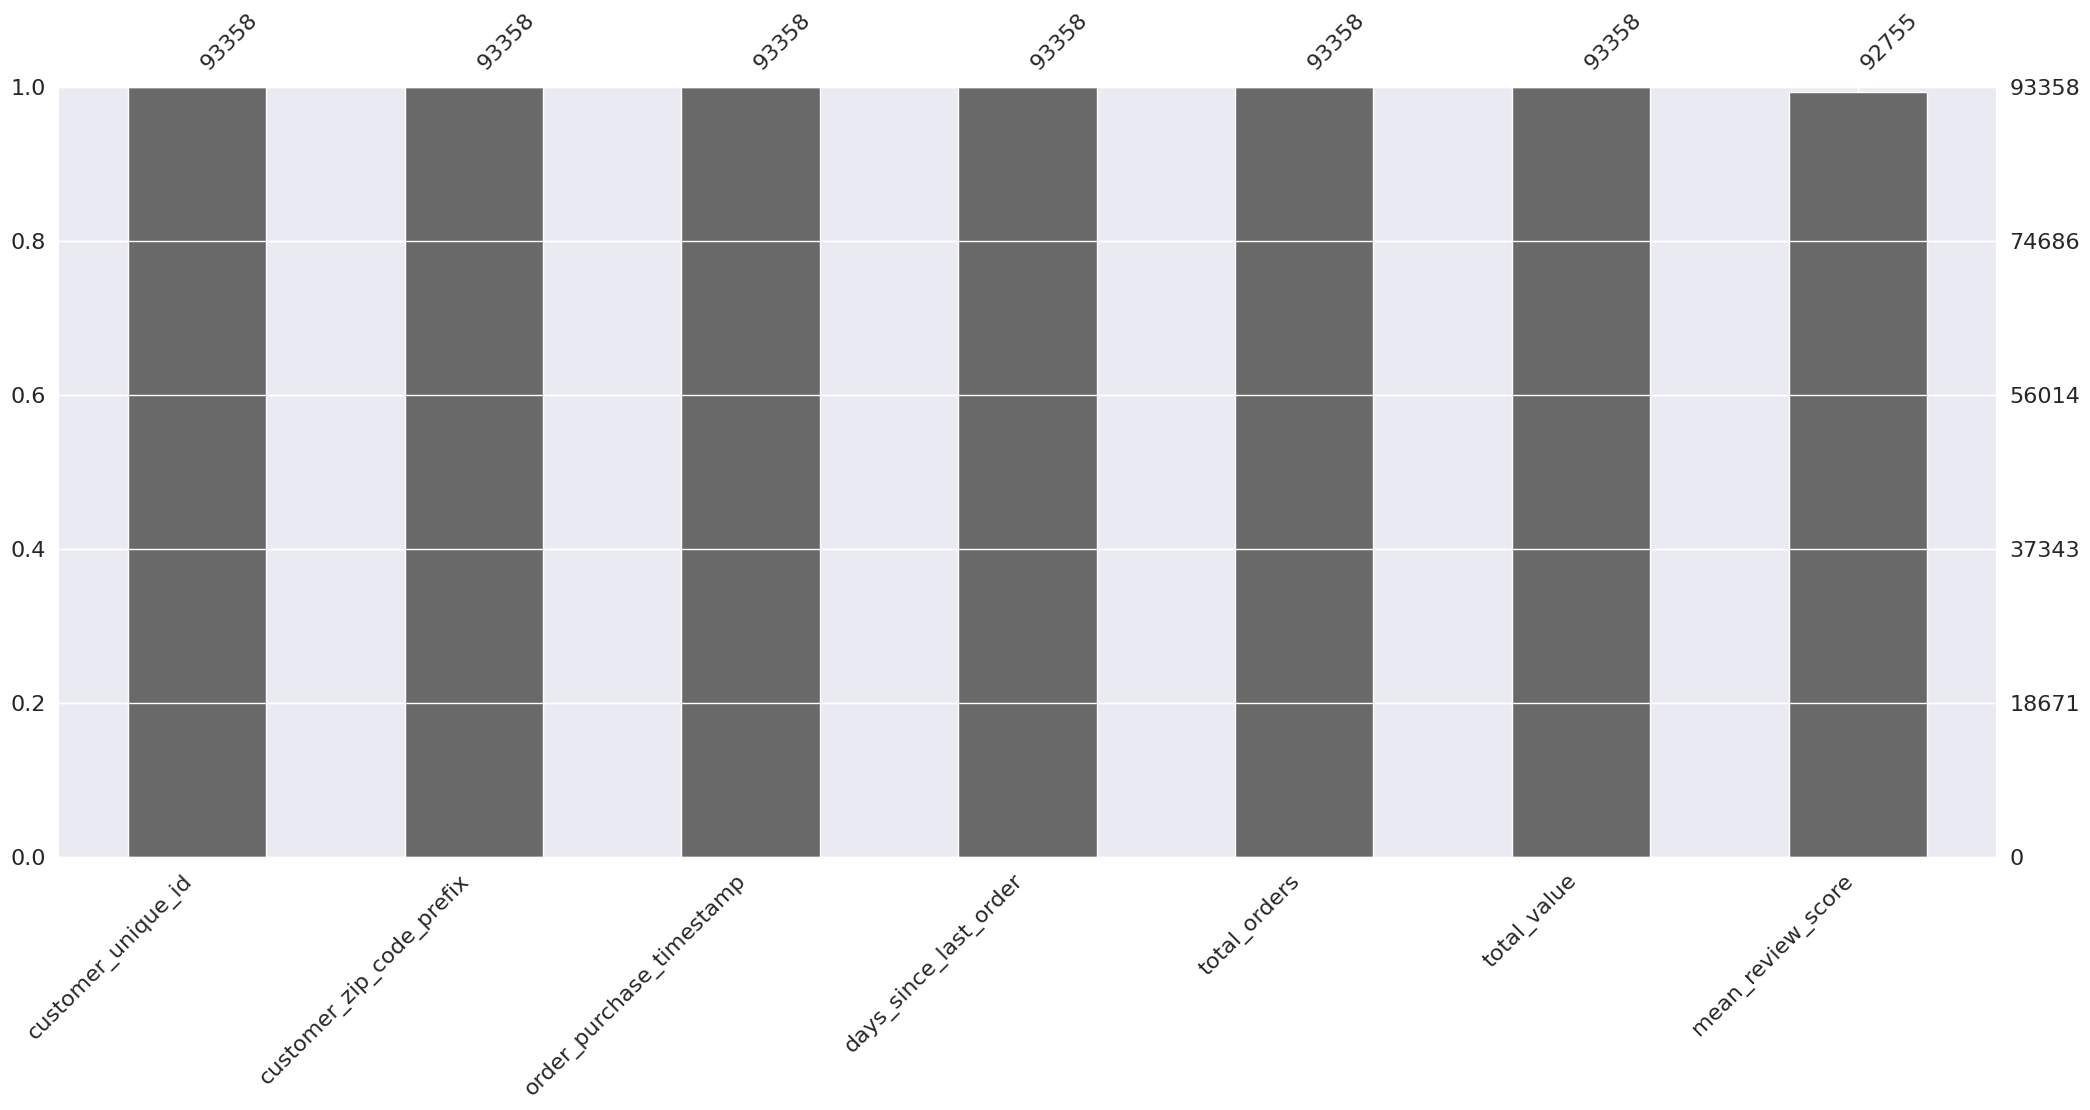

In [35]:
# Show the total numbers of value for each row
msno.bar(df)

Définissons une fonction pour notre analyse

In [36]:
def print_statistics(dataframe, feature, display_plots=True):
    ''' 
    Print statistics and visualizations for a specific feature in a dataframe.

    Parameters:
        - dataframe (pd.DataFrame): The dataframe containing the data.
        - feature (str): The feature (column name) to analyze.
        - display_plots (bool): Whether to display the plots (default: True).

    Returns:
        - pd.DataFrame: A dataframe with statistical values for the feature with :
            * Minimum value
            * Maximum value
            * Mode 
            * Mean
            * Median
            * Variance
            * Standard deviation
            * Skewness
            * Kurtosis
    
    Prints:
        - Empirical distribution
        - Interquartile range
        - Density estimation
    '''
    # Check if the feature exists in the dataframe
    if feature not in dataframe.columns:
        raise ValueError(f"La colonne '{feature}' n'existe pas dans le dataframe.")
    # Check if the feature is numeric, otherwise we can't get the statistics
    if not pd.api.types.is_numeric_dtype(dataframe[feature]):
        return f"La colonne '{feature}' doit contenir des données numériques."
        
    print("------------------------------------------------")
    print(f"     Analyse de la feature {feature}")
    print("------------------------------------------------")

    # Create the list of statistics
    statistics = {
        "Min": dataframe[feature].min(),
        "Max": dataframe[feature].max(),
        "Mode": dataframe[feature].mode()[0],
        "Moyenne": dataframe[feature].mean(),
        "Mediane": dataframe[feature].median(),
        "Variance": dataframe[feature].var(ddof=1),
        "Ecart type": dataframe[feature].std(),
        "Skewness": dataframe[feature].skew(),
        "Kurtosis": dataframe[feature].kurtosis(),
    }

    # Convert the list to DataFrame
    df_statistiques = pd.DataFrame.from_dict(statistics, orient='index', columns=["Value"])

    if display_plots :
        # Configure the grid for plots
        plt.figure(figsize = (20, 6))
        grid = plt.GridSpec(1, 3, wspace=0.5, hspace=0.3)
        
        # Empirical distribution
        plt.subplot(grid[0,0])
        dataframe[feature].hist(density=True)
        plt.title("Distribution empirique", fontweight="bold")
        plt.xlabel(f"{feature}")
        plt.ylabel("Répartition")
        plt.grid(axis="x")
        
        # Interquartile range
        plt.subplot(grid[0,1])
        dataframe.boxplot(column=[feature], vert=True)
        plt.title("Ecarts interquartile", fontweight="bold")
    
        # Density estimation
        plt.subplot(grid[0,2])
        sns.kdeplot(data=dataframe[feature], fill=True)
        plt.title("Estimation de la densité", fontweight="bold")
        plt.xlabel(f"{feature}")
        plt.ylabel("Densité")
        plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
        # Display the plots
        plt.show()
        
    return df_statistiques

La colonne 'customer_unique_id' doit contenir des données numériques.


------------------------------------------------
     Analyse de la feature customer_zip_code_prefix
------------------------------------------------


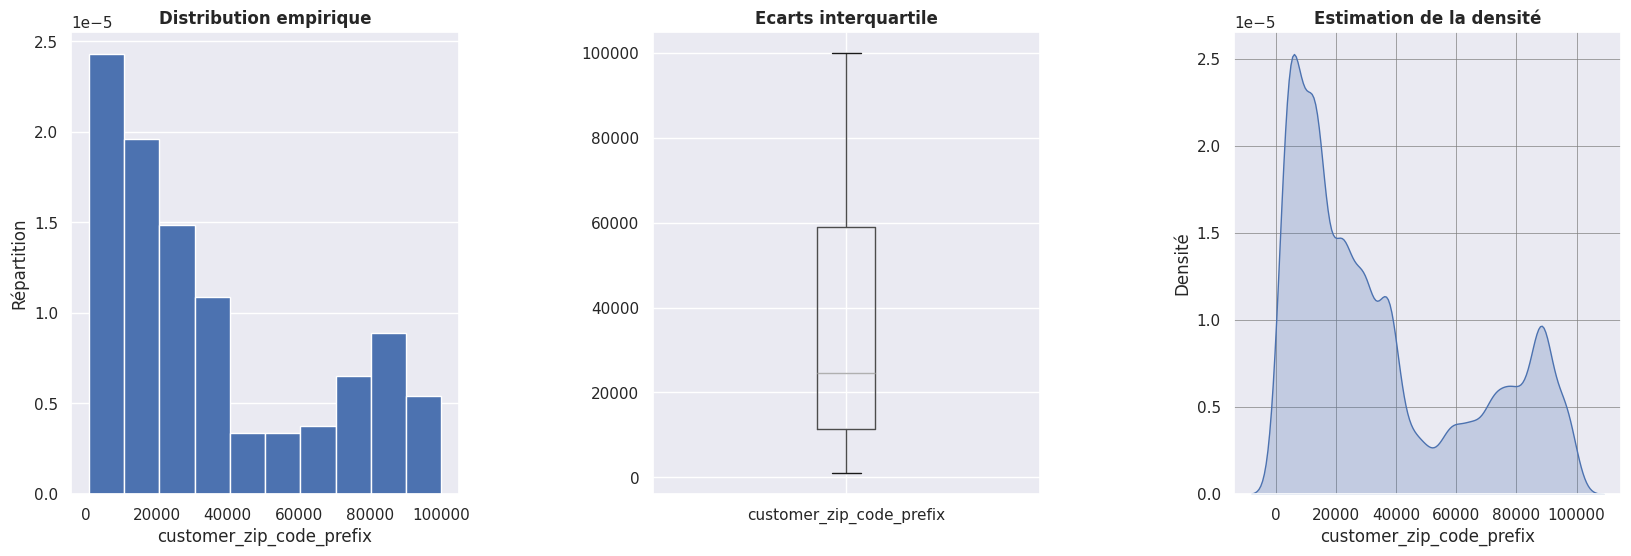

                   Value
Min         1.003000e+03
Max         9.998000e+04
Mode        2.279000e+04
Moyenne     3.523565e+04
Mediane     2.445100e+04
Variance    8.905377e+08
Ecart type  2.984188e+04
Skewness    7.735457e-01
Kurtosis   -7.992580e-01


La colonne 'order_purchase_timestamp' doit contenir des données numériques.


------------------------------------------------
     Analyse de la feature days_since_last_order
------------------------------------------------


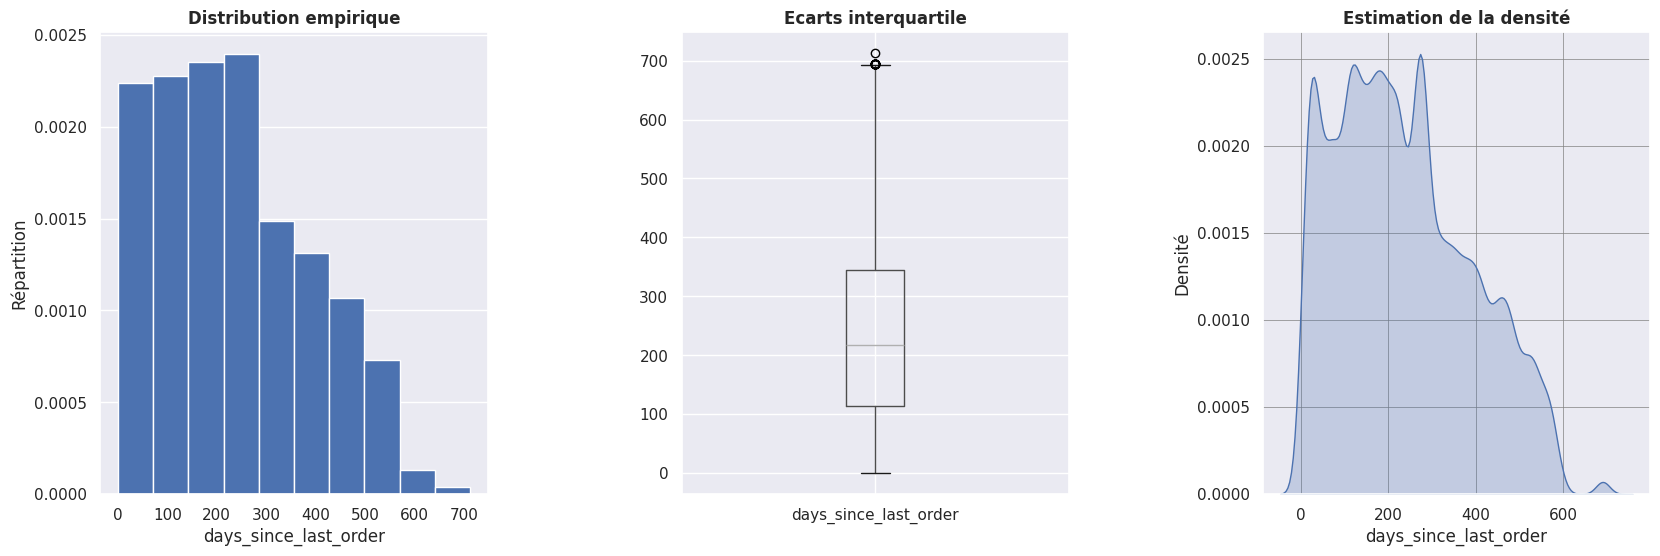

                   Value
Min             0.000000
Max           713.000000
Mode          277.000000
Moyenne       236.941773
Mediane       218.000000
Variance    23284.151499
Ecart type    152.591453
Skewness        0.447434
Kurtosis       -0.661062


------------------------------------------------
     Analyse de la feature total_orders
------------------------------------------------


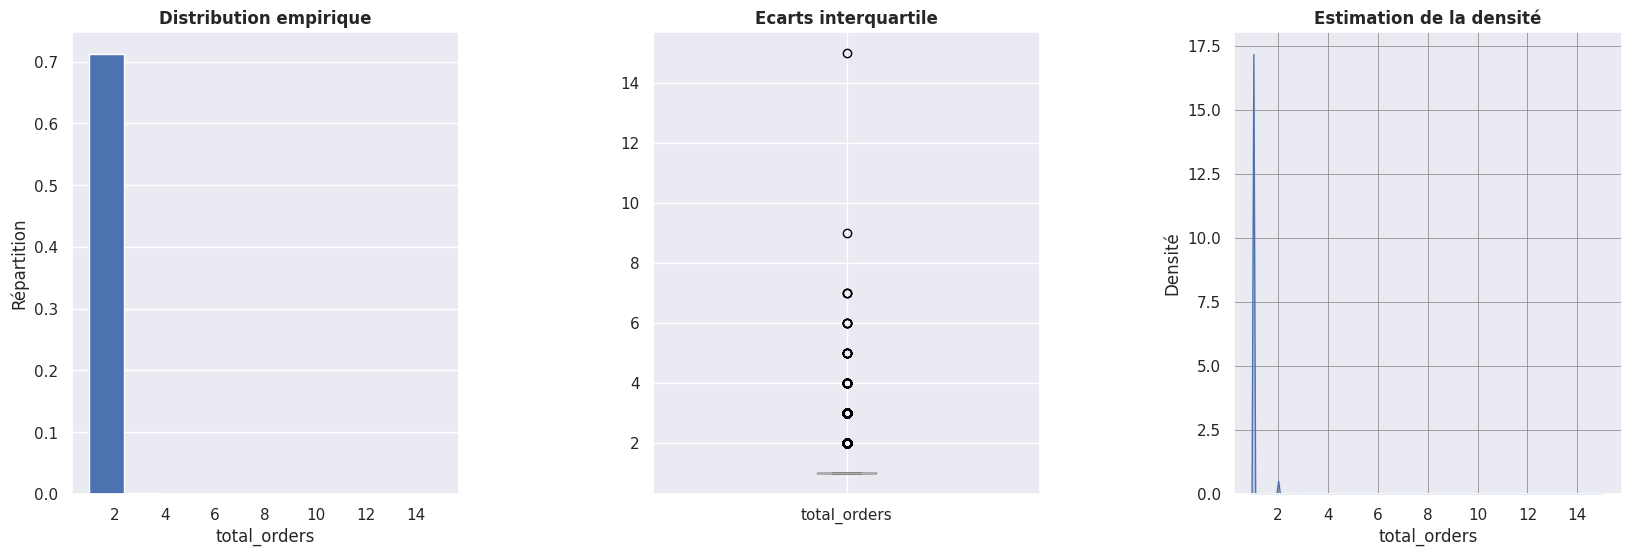

                 Value
Min           1.000000
Max          15.000000
Mode          1.000000
Moyenne       1.033420
Mediane       1.000000
Variance      0.043722
Ecart type    0.209097
Skewness     11.095156
Kurtosis    323.551045


------------------------------------------------
     Analyse de la feature total_value
------------------------------------------------


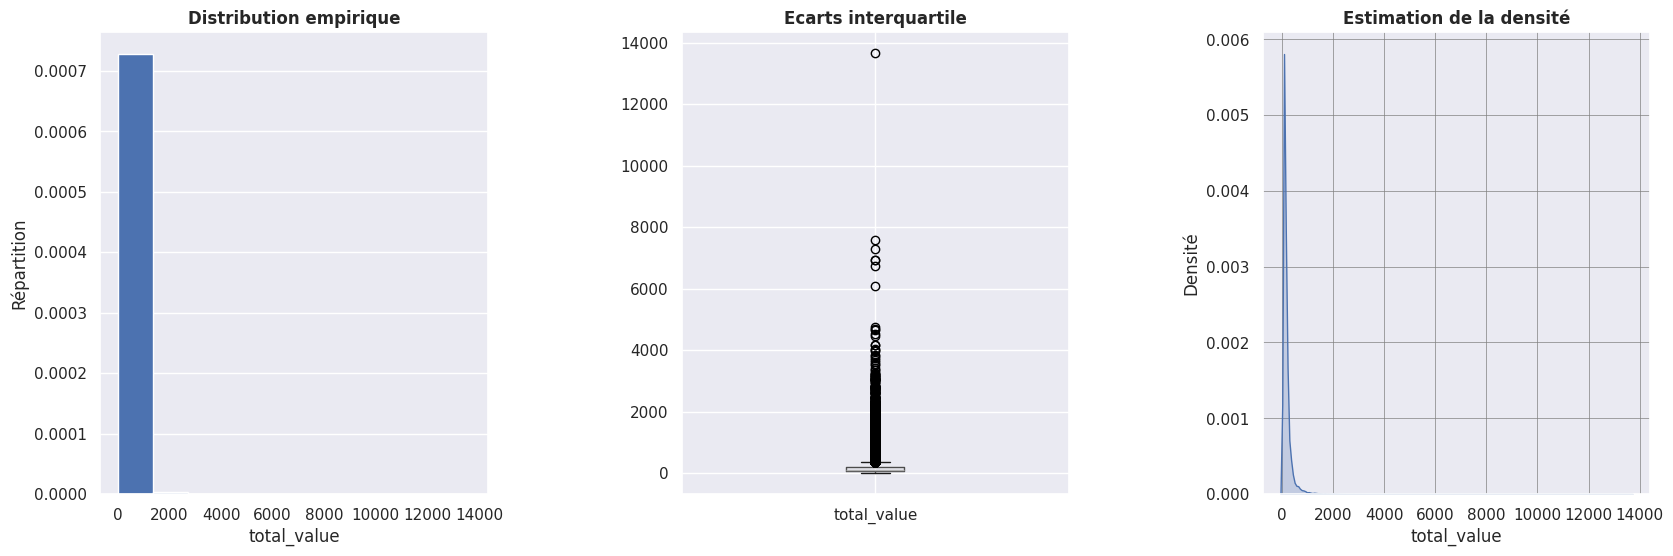

                   Value
Min             0.000000
Max         13664.080000
Mode           77.570000
Moyenne       162.482191
Mediane       106.100000
Variance    50141.041491
Ecart type    223.921954
Skewness        9.301236
Kurtosis      244.928371


------------------------------------------------
     Analyse de la feature mean_review_score
------------------------------------------------


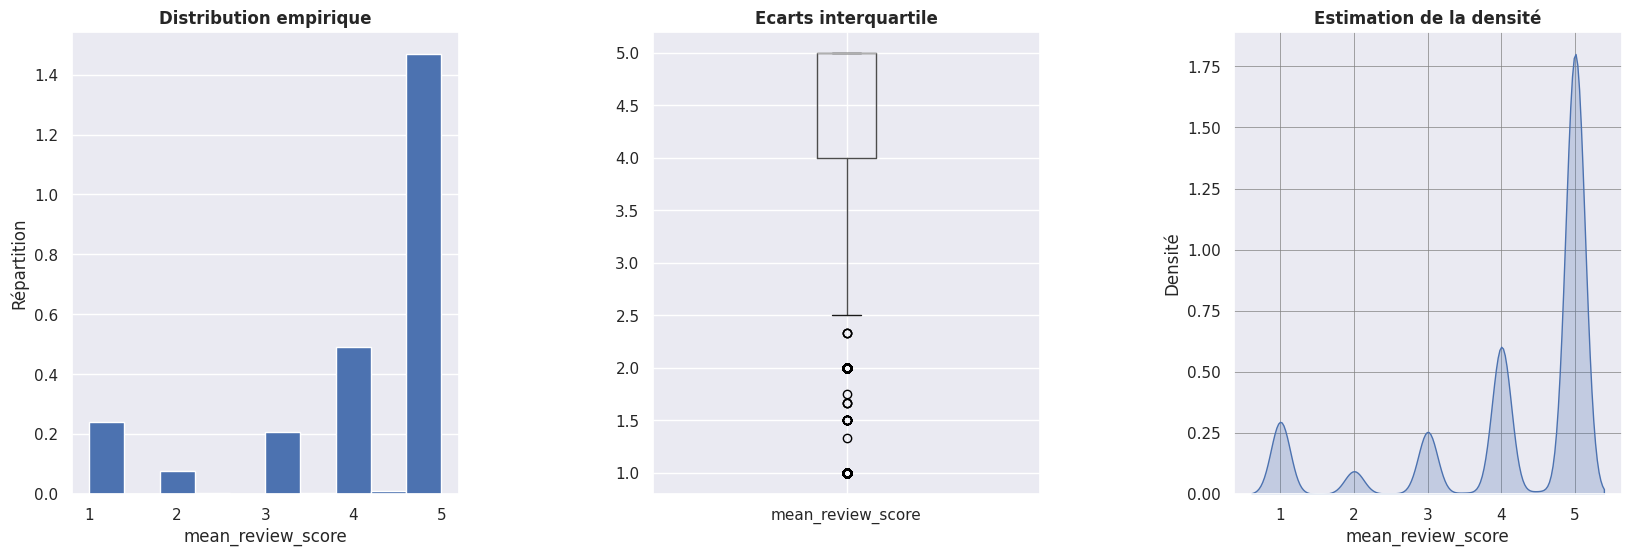

               Value
Min         1.000000
Max         5.000000
Mode        5.000000
Moyenne     4.153680
Mediane     5.000000
Variance    1.639719
Ecart type  1.280515
Skewness   -1.478786
Kurtosis    0.960023




In [37]:
# Use the previously defined function to print statistics
for feature in df.columns.to_list():
    df_statistiques = print_statistics(df, feature)
    print(df_statistiques)
    print("\n")

## Valeurs manquantes mean_review_score

La variable mean_review_score présente des valeurs manquantes, nous allons les compléter à l'aide de la valeur moyenne de la colonne

In [38]:
# Use the mean of review_score to impute the missing values
df.loc[df["mean_review_score"].isnull(), "mean_review_score"] = df["mean_review_score"].mean()

# Exportons nos données

In [39]:
# Export the data to a csv file
df.to_csv("data_cleaned.csv")